# Blondie Or Not
- In Octoober of 2020 several of us had a dispute as to if BUNKO's hair was blond or not
- This is a program which calculates different simmilarity of bunkos hair to blond(yellow) or brown ...
- This program does not take into account lighting affects but these can be mitigated by sampling

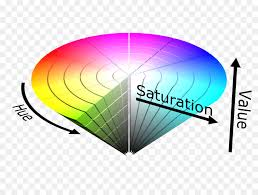

## Dependancies

In [1]:
!pip install pillow
!pip install mlxtend  

In [2]:
#Import Pillow
#%matplotlib inline
%matplotlib notebook

In [3]:
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.decomposition import PCA
import numpy as np
asarray = np.asarray
import random
import time
import colorsys
import PIL
import tensorflow as tf
import math
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors.ball_tree import BallTree
from mpl_toolkits.mplot3d import Axes3D
BallTree.valid_metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import glob
from sklearn.utils import shuffle
import tqdm

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.ball_tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Color Conversion Functions

In [4]:
#https://gist.github.com/leetrout/2382411
def hex_to_rgb(hex_str):
    """Returns a tuple representing the given hex string as RGB.
    
    >>> hex_to_rgb('CC0000')
    (204, 0, 0)
    """
    if hex_str.startswith('#'):
        hex_str = hex_str[1:]
    return tuple([int(hex_str[i:i + 2], 16) for i in range(0, len(hex_str), 2)])
def scale_rgb_tuple(rgb, down=True):
    """Scales an RGB tuple up or down to/from values between 0 and 1.
    
    >>> scale_rgb_tuple((204, 0, 0))
    (.80, 0, 0)
    >>> scale_rgb_tuple((.80, 0, 0), False)
    (204, 0, 0)
    """
    if not down:
        return tuple([int(c*255) for c in rgb])
    return tuple([round(float(c)/255, 2) for c in rgb])

def hex_to_hsl(hex_str):
    rgbs = scale_rgb_tuple(hex_to_rgb(hex_str))
    return colorsys.rgb_to_hls(rgbs[0],rgbs[1],rgbs[2])

def clamp(x):
    return max(0,min(x,255))

def rgbToHex(r,g,b):
    return "{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))


## Image to Dataset Adder

In [5]:
def hexFromImg(path):
    image = PIL.Image.open(path);
    imageArray = asarray(image)
    hexColors=set()
    # For the Image
    for ix in range(imageArray.shape[0]):
        for iy in range(imageArray.shape[1]):
            # For the pixel
            rgb = tuple([ imageArray[ix,iy,iz] for iz in range(imageArray.shape[2])])
            hexColors.add(rgbToHex(rgb[0],rgb[1],rgb[2]))
    return hexColors

## Color Constants (Training Dataset)
- A color space has been very hard to define a color space for both brown and yellow. 
- Although yellow is easy ... brown is incredibly complex even as to how computer screens can even give the effect of a brown color (as no such brown light exists!) 
- A reasonably objective google search was done and colors that were classified as blond or brown were put into their respective categories ... 
- This (small) dataset was created by Michael Naguib

In [6]:
# Specify an = # of colors from each target... 
# Some preprocessing will need to be done to remove duplicates... (edge case)
# Authority: https://icolorpalette.com/color/dirty-blonde
canonicalBlond="faf0be"
_blondColors=set([
    canonicalBlond,
    "b38b67","c89f73","d9b380","fbe7a1",
    'dfc393',"DCB596","E0C09F","DFBD91","DDC394","DECB99","DEB38F"
    "fcf9f5","faf6ef","f8f2e8","f6efe2","f4ebdc",'f2e8d6',
    "f1e4cf","efe1c9","edddc3","ebdabc","e9d6b6","e7d3b0",
    "e5cfaa","e3cca3","e2c89d","e0c597","dec190","dcbe8a",
    "daba84","d8b77d","d6b377","d5b071","d3ac6b","d1a964",
    "cfa55e","cda258","cb9e51","c99b4b","c79745","c6943f",
    "c39039","bc8b37","b68736","b08234","a97d32","a37930",
    "9d742e","976f2c","906b2a","8a6629","846127","7d5d25",
    "775823","715321","6b4f1f","644a1d","5e451b","58411a",
    "513c18","4b3716","453314","3e2e12","382910","32250e",
    "2c200d","251b0b","1f1709","191207","120d05","0c0903",
    "edd96d","d1b519","eace2c","ffdb0f","f4e590","fcf1b3",
    "f2f29b","eaea70","d8d838","eded38","fbff11","fdff87",
    "fbfcb8"
])
#Authority: https://www.schemecolor.com/brown-hair-color-scheme.php
# https://www.color-hex.com/color-palette/3627
#https://www.colorhexa.com/654321
#https://icolorpalette.com/color/brown
canonicalBrown="a52a2a"
_brownColors=set([
    canonicalBrown,
    "2d170e","4d2d1a","6d4730","a97e6d","cc9f88"
    "23120B","3D2314","5A3825","CC9966","2C1608"
    "905424","bb6d3e","da874c","ed9352","ffb464"
    "654321","653700",
    "fff9f2","fff5ea","fef1e2","feeeda","feead2","fee6c9",
    "fee3c1","fedfb9","fedbb1","ffd7a9","ffd4a1","ffd099",
    "ffcc90","ffc988","ffc580","ffc178","ffbd70","ffba68",
    "ffb65f","ffb257","ffaf4f","ffab47","ffa73f","ffa337",
    "ffa02e","ff9c26","ff981e","ff9516","ff910e","ff8d06",
    "fc8900","c36a00","b60000","b36100","ab5d00","a35800",
    "9b5400","924f00","8a4b00","824700","7a4200","723e00",
    "6a3900","613500","613500","512c00","492700","492700",
    "391f00","301a00","281600","201100","180d00","100800",
    "653700","94450B" 
])

canonicalBlack="000000"
_blackColors=set([
    canonicalBlack,
    "f8f8f8","f4f4f4","f0f0f0","ececec","e8e8e8","e4e4e4",
    "e0e0e0","dcdcdc","d8d8d8","d4d4d4","d0d0d0","ccc000",
    "c7c7c7","c3c3c3","bfbfbf","bbb000","b7b7b7","b3b3b3",
    "afafaf","ababab","a7a7a7","a3a3a3","9f9f9f","9b9b9b",
    "969696","929292","8e8e8e","8a8a8a","868686","828282",
    "7e7e7e","7a7a7a","767676","727272","6e6e6e","6a6a6a",
    "666000","616161","5d5d5d","595959","555000","515151",
    "4d4d4d","494949","454545","414141","3d3d3d","393939",
    "353535","303030","303030","282828","242424","202020",
    "1c1c1c","181818","141414","101010","0c0c0c","080808"
 
])

canonicalGinger=""
_gingerColors=set([
    canonicalGinger,
 
])

# Here is where the original color space keys are specifieds
colorSpaces={
    "black":_blackColors,
    "brown":_brownColors,
    #"ginger":_gingerColors,
    "blond":_blondColors
}
print(f"This program classifies into {colorSpaces.keys()}")

This program classifies into dict_keys(['black', 'brown', 'blond'])


## Manually Add Image data 

## Add Images to Color Palate based on Directory

In [7]:
for colorKey in colorSpaces:
    for fname in glob.glob("./"+colorKey+"/*.*"):
        print(f"Considering {fname} as {colorKey} Data")
        hexCodes = hexFromImg(fname)
        colorSpaces[colorKey].update(hexCodes)

Considering ./black\blackHair.PNG as black Data
Considering ./black\blackHair2.PNG as black Data
Considering ./black\BlackHair3.PNG as black Data
Considering ./black\BlackHair4.PNG as black Data
Considering ./black\blackHair5.PNG as black Data
Considering ./black\BlackHair6.PNG as black Data
Considering ./brown\234brown.PNG as brown Data
Considering ./brown\bbrrrrown.PNG as brown Data
Considering ./brown\br.PNG as brown Data
Considering ./brown\brn.PNG as brown Data
Considering ./brown\broooooonnn.PNG as brown Data
Considering ./brown\brooown.PNG as brown Data
Considering ./brown\browiiin.PNG as brown Data
Considering ./brown\brown.PNG as brown Data
Considering ./brown\brown12.PNG as brown Data
Considering ./brown\brown1245.PNG as brown Data
Considering ./brown\brown211.PNG as brown Data
Considering ./brown\brown234.PNG as brown Data
Considering ./brown\brown234643.PNG as brown Data
Considering ./brown\Brown3.PNG as brown Data
Considering ./brown\brown3000.PNG as brown Data
Considering

## Preprocessing
- Convert to the Encoding Needed
- Randomly sample from the spaces

In [8]:
# Preprocessing Convert to HLS color spaces
print("Preprocessing HEX space to HLS Space")
hlsColorSpaces={colorKey:[hex_to_hsl(color) for color in colorSpaces[colorKey]] for colorKey in colorSpaces}
                          
#Shuffle each of the spaces:
print("Randomizing the space sequences for HLS space")
for colorKey in hlsColorSpaces:
    random.shuffle(hlsColorSpaces[colorKey])
# Sampled Space
minSize=-1
for colorKey in hlsColorSpaces:
    print(f"Space:{colorKey} Size:{len(hlsColorSpaces[colorKey])}")
    if len(hlsColorSpaces[colorKey])<minSize or minSize==-1:
        minSize=len(hlsColorSpaces[colorKey])
N_SAMPLES=int(minSize*0.9)
print(f"Sampling Size {N_SAMPLES} (10% hit on the smallest size)")
sampledSpace = {colorKey:np.array(hlsColorSpaces[colorKey][0:min(N_SAMPLES,len(hlsColorSpaces[colorKey]))]) for colorKey in hlsColorSpaces}

                          # Preprocessing:
#  Convert to hsl
#_br=[hex_to_hsl(color) for color in _brownColors]
#_bl=[hex_to_hsl(color) for color in _blondColors]
# Shuffle the lists
#random.shuffle(_br)
#random.shuffle(_bl)
## Adaptive resampling

#print(f"Before Adaptive Sampling Brown#:{len(_br)} Blond#:{len(_bl)}")
# Sample only at most N
#N_SAMPLES=140000
#print(f"sampling randomly {N_SAMPLES}")
#Form the arrays
#brownColors = np.array(_br[0:min(N_SAMPLES,len(_br))])
#blondColors = np.array(_bl[0:min(N_SAMPLES,len(_bl))])
#l'
#print(f"Length Check passed: {brownColors.size==blondColors.size}")

Preprocessing HEX space to HLS Space
Randomizing the space sequences for HLS space
Space:black Size:25520
Space:brown Size:144417
Space:blond Size:231963
Sampling Size 22968 (10% hit on the smallest size)


## Generate a Plot of the colors: 

<IPython.core.display.Javascript object>


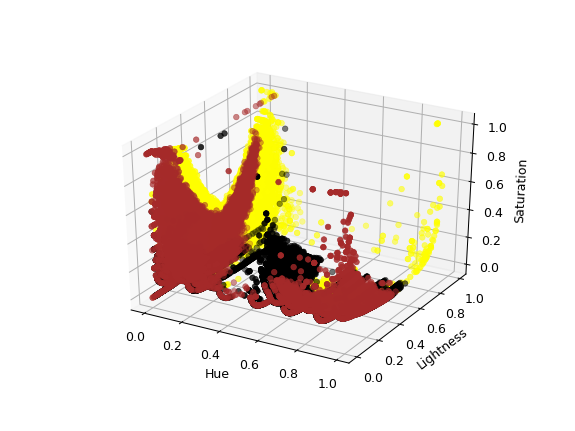

In [10]:
# Access Slicing Functions for each coordinate
X = lambda a : a[:,0:1]
Y = lambda a : a[:,1:2]
Z = lambda a : a[:,2:3]

# Plot Setup
fig = plt.figure()
ax = plt.axes(projection='3d')

# Axis Labels
ax.set_xlabel('Hue')
ax.set_ylabel('Lightness')
ax.set_zlabel('Saturation')

colorNameToRGB={
    "black":"black",
    "brown":"#"+canonicalBrown,
    "blond":"yellow",
}

for colorKey in sampledSpace:
    ax.scatter(X(sampledSpace[colorKey]),Y(sampledSpace[colorKey]),Z(sampledSpace[colorKey]),color=colorNameToRGB[colorKey],linewidth=0.5)
# Brown Colors
#ax.scatter(X(brownColors),Y(brownColors),Z(brownColors), color="#"+canonicalBrown, linewidth=0.5);
# Blond Colors
#ax.scatter(X(blondColors),Y(blondColors),Z(blondColors), color="yellow",linewidth=0.5);
# Show the plot
plt.show()

## Fit the KNN Model
- Running K Fold Validation
- Retraining for different model sizes
- Evaluating based on different metrics

In [11]:
#Prepare the Data:  colorName: int associated with that number
print("Generating Classification Numbers")
colorKeyToInt={part[0]:part[1] for part in zip(hlsColorSpaces.keys(),range(len(hlsColorSpaces.keys())))}
intToColorKey = {colorKeyToInt[colorKey]:colorKey for colorKey in colorKeyToInt}
for colorKey in colorKeyToInt:
    print(f"Color: {colorKey} Has ID: {colorKeyToInt[colorKey]}")

#Concatenate the data into one BIIIIG long array
x_data = None
y_data = None
first=True
for colorKey in colorKeyToInt:
    if first:
        x_data = sampledSpace[colorKey]
        y_data = colorKeyToInt[colorKey]*np.ones(len(sampledSpace[colorKey]),dtype=int)
        first=False
    else:
        x_data = np.concatenate((x_data,sampledSpace[colorKey]), axis=0)
        y_data = np.concatenate((y_data,colorKeyToInt[colorKey]*np.ones(len(sampledSpace[colorKey]),dtype=int)),axis=0)
# Prepare the data for classification: 0 for blond 1 for brown
#x_data = np.concatenate((brownColors,blondColors), axis=0)
#y_data = np.concatenate((np.ones(len(brownColors),dtype=int),np.zeros(len(blondColors),dtype=int)), axis=0)
x_data, y_data = shuffle(x_data, y_data, random_state=random.randint(0,10))

Generating Classification Numbers
Color: black Has ID: 0
Color: brown Has ID: 1
Color: blond Has ID: 2


In [12]:
# Performing 3 Fold Validation
kf = KFold(n_splits=3,shuffle=True)

# Generating Range
nearestCounts = list(range(3,45,3))

# Create a list of errors (per each fold)
errors=[]

#For each fold
currentFold=0
for train_index, test_index in kf.split(x_data):
    #Append a place to store the errors for the fold
    errors.append([])
    
    
    # for each KNN (n nearest)
    for n in nearestCounts:
        # Create the KNN Classifier
        classifier = KNeighborsClassifier(n_neighbors=n,algorithm='kd_tree')
        
        # Extract Train Data
        train_data_x = []
        train_data_y = []
        for index in train_index:
            train_data_x.append(x_data[index])
            train_data_y.append(y_data[index])
            
        #FIT the classifer
        print(f"Fitting Classifier Fold:{currentFold}  N-Nearest:{n}")
        classifier.fit(np.array(train_data_x),np.array(train_data_y))

        #Extract Test Data
        test_data_x = []
        test_data_y = []
        for index in test_index:
            test_data_x.append(x_data[index])
            test_data_y.append(y_data[index])
        
        #Predict
        print("  Predicting")
        prediction = classifier.predict(test_data_x)
        print("  Error calculations")
        # Calculate Mean error for the fold
        errors[currentFold].append(np.mean(prediction != test_data_y))
        
    #Increment the fold
    currentFold+=1
    
print("Done")

Fitting Classifier Fold:0  N-Nearest:3
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:6
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:9
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:12
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:15
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:18
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:21
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:24
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:27
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:30
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:33
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:36
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:39
  Predicting
  Error calculations
Fitting Classifier Fold:0  N-Nearest:42
 

## Plot Mean Error vs K value

<IPython.core.display.Javascript object>


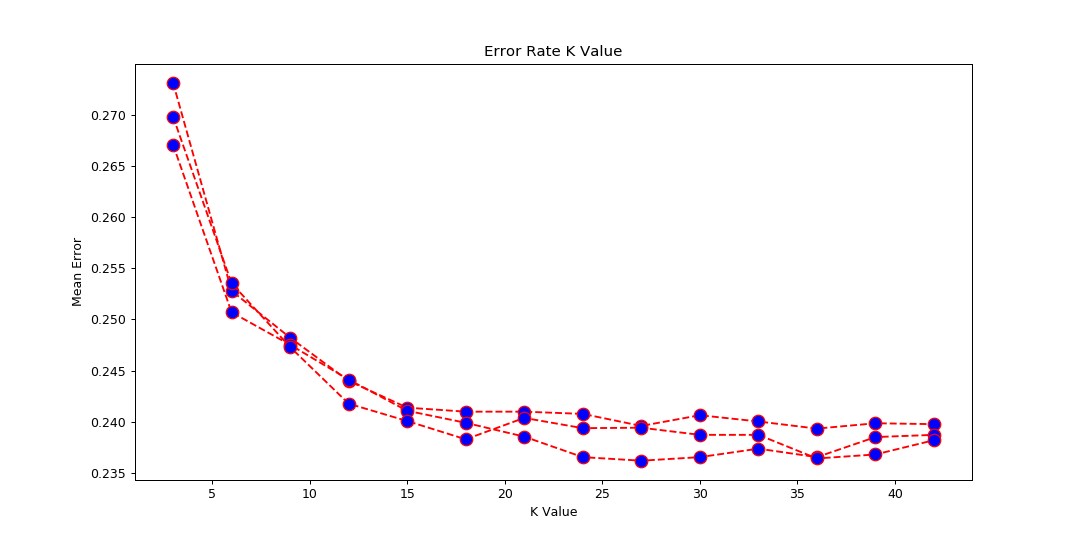

Text(0, 0.5, 'Mean Error')

In [13]:
plt.figure(figsize=(12, 6))
for error in errors:
    plt.plot(nearestCounts, error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Create the Main Classifier Model for use 
- Human must specify K value for best accuracy

In [14]:
classifier = KNeighborsClassifier(n_neighbors=40,algorithm='kd_tree')
classifier.fit(x_data,y_data)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                     weights='uniform')

## Create a function which loops over the pixels of the image and classifies according to the model

In [15]:
def classify_pic(pic,classifier):
    # Create an array of the pixel colors
    hlsColors = []
    
    # Count of each class: will be converted to fraction
    classCoverage={colorKey:0 for colorKey in sampledSpace }
    
    #d = lambda x: np.delete(x,1,axis=1)
    
    # For the Image
    for ix in tqdm.tqdm(range(pic.shape[0])):
        for iy in range(pic.shape[1]):
            # For the pixel
            rgbs= scale_rgb_tuple(tuple([ pic[ix,iy,iz] for iz in range(pic.shape[2])]))
            hsltuple=colorsys.rgb_to_hls(rgbs[0],rgbs[1],rgbs[2])
            #Append that pixel to the list
            hlsColors.append(hsltuple)
    
    # Predict the color based on the classifier
    #predictions = classifier.predict(d(np.array(hlsColors)))
    predictions = classifier.predict(np.array(hlsColors))
    
    # Sum the counts for each class
    for i in range(0,predictions.size):
        ck = intToColorKey[predictions[i]]
        classCoverage[ck]+=1
    # scale them
    for colorKey in classCoverage:
        classCoverage[colorKey] = classCoverage[colorKey]/predictions.size
    
    # Calculate the ratio of Blonds: (0 for blond 1 for brown)
    #return np.sum(predictions)/len(predictions)
    return classCoverage


In [16]:
def generateColorImage(rgbArray,dim=(3,3)):
    '''
    Creates a  AxB sized image where dim=(A,B)
    of the specified rgb color (R,G,B)
    where R,G,B are integers [0,255]
    '''
    pic = np.ones((dim[0],dim[1],3),dtype=np.int16)
    for ix in range(pic.shape[0]):
        for iy in range(pic.shape[1]):
            for iz in range(rgbArray.shape[0]):
                #print(f"{ix},{iy},{iz}")
                pic[ix,iy,iz] = rgbArray[iz]
    return pic

## Testing Procedure: have it classify known Targets

In [17]:
print("0 means Blond 1 means Brown")
# Raw pixel Based
d = lambda x: np.delete(x,1,axis=1)
brown=np.array([hex_to_hsl(canonicalBrown)])
blond=np.array([hex_to_hsl(canonicalBlond)])
print(f" Brown {brown} Predicted : {classifier.predict(brown)}")
print(f" Blond {blond} Predicted : {classifier.predict(blond)}")

# Iterated Pixel test
# Raw pixel Based
d = lambda x: np.delete(x,1,axis=1)
brown=np.array([hex_to_hsl(list(_brownColors)[random.randint(0,len(_brownColors)-1)])])
blond=np.array([hex_to_hsl(list(_blondColors)[random.randint(0,len(_blondColors)-1)])])
print(f" Brown {brown} Predicted : {classifier.predict(brown)}")
print(f" Blond {blond} Predicted : {classifier.predict(blond)}")

0 means Blond 1 means Brown
 Brown [[0.         0.405      0.60493827]] Predicted : [2]
 Blond [[0.13768116 0.865      0.85185185]] Predicted : [2]
 Brown [[0.         0.45       0.13333333]] Predicted : [1]
 Blond [[0.05882353 0.545      0.18681319]] Predicted : [2]


## Image to Classify

In [21]:
#Target File: the picture file that will be analyzed
#targetFile="ClassifyMeBunko.PNG"#
targetFile="./ClassificationTarget/ClassifyMeBunkoFromBunko.PNG"
#targetFile="ClassifyMeChristina.PNG"
#targetFile="ClassifyMeMichael.PNG"
#targetFile="ClassifyB.PNG"
#targetFile="ClassifyMeNate.PNG"
#targetFile="ClassifyMeBunko1.PNG"
#targetFile="ClassifyMeMarc.PNG"
#targetFile="ClassifyMeNate1.PNG"
#targetFile="ClassifyMeMichael1.PNG"

## Load the Image into a NP Array

<IPython.core.display.Javascript object>


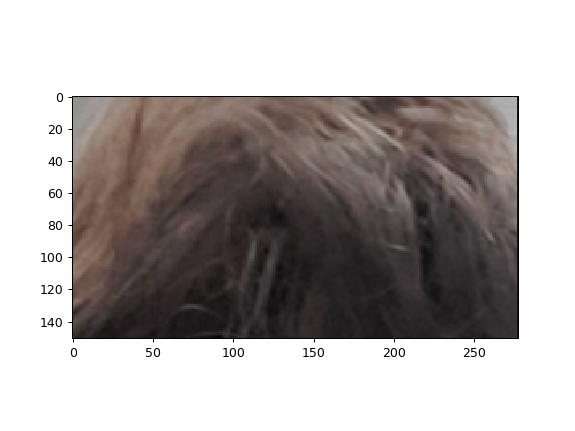

In [22]:
image = PIL.Image.open(targetFile);
imageArray = asarray(image)
plt.figure()
plt.imshow(imageArray)
plt.show()

## Classify the Image

In [23]:
print("Image Has the Following Classification Decomposition")
cDecomp = classify_pic(imageArray,classifier)
for colorKey in cDecomp:
    print(f"Color: {colorKey} {round(cDecomp[colorKey]*1000)/10}%")

 49%|████▉     | 74/151 [00:00<00:00, 734.12it/s]

Image Has the Following Classification Decomposition


100%|██████████| 151/151 [00:00<00:00, 731.19it/s]


Color: black 46.0%
Color: brown 48.5%
Color: blond 5.5%
